# Imports

In [2]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM,GRU,Dense,MaxPooling1D,Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import add,Conv1D
from tensorflow.keras.layers import Input,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping




from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

## Read Respiratory Cycle Data

In [3]:
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

In [4]:
import os
from collections import Counter

# Ścieżka do katalogu z plikami audio
directory_path = "../audio_and_txt_files_only_micro"

# Pobierz listę plików w katalogu
filenames = [f for f in os.listdir(directory_path) if f.endswith('.wav')]
# print(filenames)

def extract_last_component(filename):
    base_name = os.path.splitext(filename)[0]
    components = base_name.split('_')
    return components[-1]

last_components = [extract_last_component(filename) for filename in filenames]
component_counts = Counter(last_components)

for component, count in component_counts.items():
    print(f"{component}: {count}")

import pandas as pd

df = pd.DataFrame(component_counts.items(), columns=['Component', 'Count'])
print(df)



AKGC417L: 646
  Component  Count
0  AKGC417L    646


In [5]:
root = directory_path

filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]
i_list = []
rec_annotations = []
rec_annotations_dict = {}
for s in filenames:
    (i,a) = Extract_Annotation_Data(s, root)
    i_list.append(i)
    rec_annotations.append(a)
    rec_annotations_dict[s] = a
recording_info = pd.concat(i_list, axis = 0)
recording_info.head()

my_index = pd.Series(list(rec_annotations_dict.keys()))

rec_annotations_dict

{'107_2b3_Al_mc_AKGC417L':     Start     End  Crackles  Wheezes
 0   0.887   2.601         1        0
 1   2.601   5.327         1        0
 2   5.327   7.923         1        0
 3   7.923  10.530         1        0
 4  10.530  13.196         1        0
 5  13.196  15.565         1        0
 6  15.565  18.054         1        0
 7  18.054  19.101         0        0,
 '107_2b3_Ar_mc_AKGC417L':     Start     End  Crackles  Wheezes
 0   0.887   2.601         1        0
 1   2.601   5.327         1        1
 2   5.327   7.923         1        1
 3   7.923  10.530         1        1
 4  10.530  13.196         1        1
 5  13.196  15.565         1        1
 6  15.565  18.054         1        1
 7  18.054  19.101         1        1,
 '107_2b3_Ll_mc_AKGC417L':     Start     End  Crackles  Wheezes
 0   0.887   2.601         1        0
 1   2.601   5.327         1        0
 2   5.327   7.923         1        0
 3   7.923  10.530         1        0
 4  10.530  13.196         1        0
 5  13.1

## Get Respiratory Cycle length and Diagnosis

In [6]:
res_rate_list = []
for i in range (646):
    cycle_df = pd.DataFrame( list(rec_annotations_dict.values())[i], columns=['Start'])
    count = cycle_df.count(axis=0)
    df = pd.DataFrame(count).T
    res_rate_list.append(df)
res_rate_list

[   Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      8,
    Start
 0      9,
    Start
 0      9,
    Start
 0      9,
    Start
 0      9,
    Start
 0      9,
    Start
 0      9,
    Start
 0      9,
    Start
 0      7,
    Start
 0      7,
    Start
 0      7,
    Start
 0      7,
    Start
 0      7,
    Start
 0      7,
    Start
 0      7,
    Start
 0      7,
    Start
 0      7,
    Start
 0      7,
    Start
 0      7,
    Start
 0      7,
    Start
 0      6,
    Start
 0      6,
    Start
 0      6,
    Start
 0      6,
    Start
 0      6,
    Start
 0      6,
    Start
 0      6,
    Start
 0 

In [7]:
res_rate_df = pd.concat(res_rate_list,ignore_index =True)
res_rate_df['filename']= my_index.values
res_rate_df['filename']= res_rate_df['filename']
res_rate_df.sort_values(by=['filename'])

,Start,filename
0,8,107_2b3_Al_mc_AKGC417L
1,8,107_2b3_Ar_mc_AKGC417L
2,8,107_2b3_Ll_mc_AKGC417L
3,8,107_2b3_Lr_mc_AKGC417L
4,8,107_2b3_Pl_mc_AKGC417L
...,...,...
641,7,213_2p2_Al_mc_AKGC417L
642,7,213_2p2_Ar_mc_AKGC417L
643,7,213_2p2_Pl_mc_AKGC417L
644,7,213_2p2_Pr_mc_AKGC417L


## Save Diagnosis Data

In [8]:
res_rate_df.to_csv('cycles_count.csv')

## Data Augmentation

In [9]:
audio_data = "C:/Users/u144572/self_development/model_ml_detekcji_szczytow_rr/Respiratory_Sound_Database/audio_and_txt_files/"

In [10]:
rr_diagnosis_df = pd.read_csv('cycles_count.csv', names=['cycles', 'filename'],header=0)
rr_diagnosis_df.head(4)

,cycles,filename
0,8,107_2b3_Al_mc_AKGC417L
1,8,107_2b3_Ar_mc_AKGC417L
2,8,107_2b3_Ll_mc_AKGC417L
3,8,107_2b3_Lr_mc_AKGC417L


In [11]:
def add_noise(data, x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data, x):
    return np.roll(data, x)

def stretch(data, rate):
    data = librosa.effects.time_stretch(data, rate)
    return data

def pitch_shift (data , rate):
    data = librosa.effects.pitch_shift(data, sr=220250, n_steps=rate)
    return data

In [12]:
def mfcc_feature_exteraction_rr(dir_):
    X_=[]
    y_=[]
    data = rr_diagnosis_df
    features = 50
    for soundDir in (os.listdir(dir_)):
        if soundDir[-3:]=='wav':             
            
            label = list(data[data['filename']==(soundDir[:-4])]['cycles'])[0]

            data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
            mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis = 0)
            X_.append(mfccs)
            y_.append(label)
            
            data_shift = shift(data_x,1600)
            mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis = 0)
            X_.append(mfccs_shift)
            y_.append(label)
            
            data_noise = add_noise(data_x,0.005)
            mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis = 0)
            X_.append(mfccs_noise)
            y_.append(label)
                
    X_data = np.array(X_)
    y_data = np.array(y_)    
    
    return X_data ,y_data

In [13]:
res_data, res_y = mfcc_feature_exteraction_rr(audio_data)

In [14]:
res_features = np.array(res_data)
res_lables = np.array(res_y)

res_features.shape , res_lables.shape

((1938, 50), (1938,))

## Data Split

In [15]:
x_train, x_val, y_train, y_val  = train_test_split(res_features, res_lables, test_size=0.175, random_state=10)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.075, random_state=10)

print (x_train.shape, x_val.shape, x_test.shape)
print (y_train.shape, y_val.shape, y_test.shape)

(1478, 50) (340, 50) (120, 50)
(1478,) (340,) (120,)


# LSTM Model

In [18]:
x_train_lstm = np.expand_dims(x_train,axis=2)
x_val_lstm = np.expand_dims(x_val,axis=2)
x_test_lstm = np.expand_dims(x_test,axis=2)

## Build Model

In [21]:
# Define the model
model = Sequential()
model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))

model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())

model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())

model.add(LSTM(256, return_sequences=True))
model.add(LSTM(128))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

# Compile the model
optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=optimiser, loss='mean_squared_error', metrics=['mae'])



C:\Users\u144572\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Train Model

In [22]:
history = model.fit(
    x_train_lstm, y_train, batch_size=16, epochs=150, validation_data=(x_val_lstm, y_val),
  )
model.save("model.h5")
model.save_weights('model.weights.h5')

Epoch 1/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 27s 254ms/step - loss: 33.8269 - mae: 5.1910 - val_loss: 7.5258 - val_mae: 1.9757
Epoch 2/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 24s 255ms/step - loss: 16.9889 - mae: 3.3301 - val_loss: 6.3455 - val_mae: 1.8230
Epoch 3/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 26s 277ms/step - loss: 14.7676 - mae: 3.0690 - val_loss: 5.3821 - val_mae: 1.6601
Epoch 4/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 27s 288ms/step - loss: 14.7560 - mae: 3.0742 - val_loss: 7.0374 - val_mae: 1.9120
Epoch 5/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 24s 260ms/step - loss: 12.5022 - mae: 2.7982 - val_loss: 5.1403 - val_mae: 1.6358
Epoch 6/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 21s 231ms/step - loss: 12.8946 - mae: 2.8258 - val_loss: 5.4370 - val_mae: 1.6843
Epoch 7/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 22s 234ms/step - loss: 11.2257 - mae: 2.7030 - val_loss: 7.2274 - val_mae: 2.0189
Epoch 8/150
93/93 ━━━━━━━━━━━━━━━━━━━━ 24s 254ms/step - loss: 11.6037 - mae: 2.6565 - val_loss: 4.5268 - val_mae: 1.5670
Epoch 9/150
93/93 ━━━━━━━━━━━━━━

In [23]:
import pickle
with open('trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

## Evaluate Model

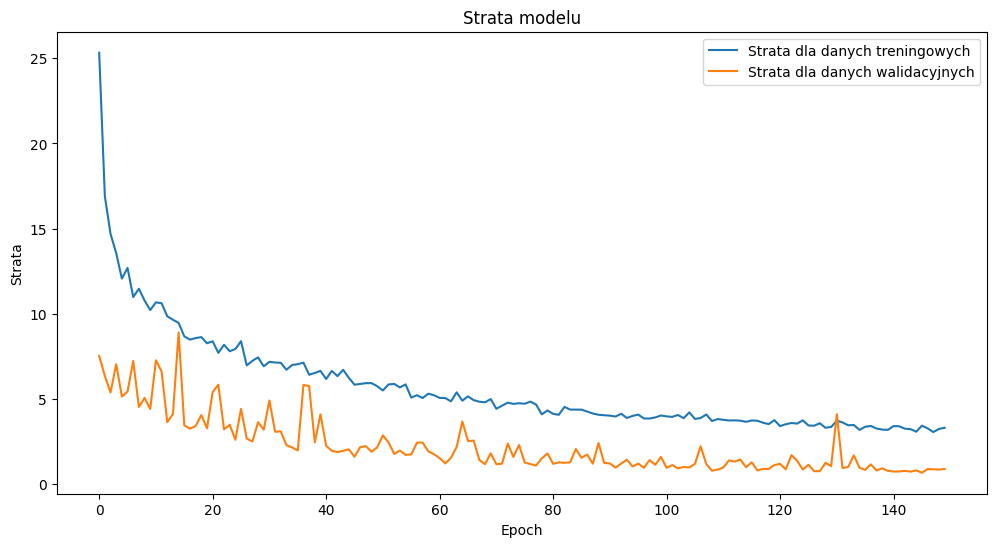

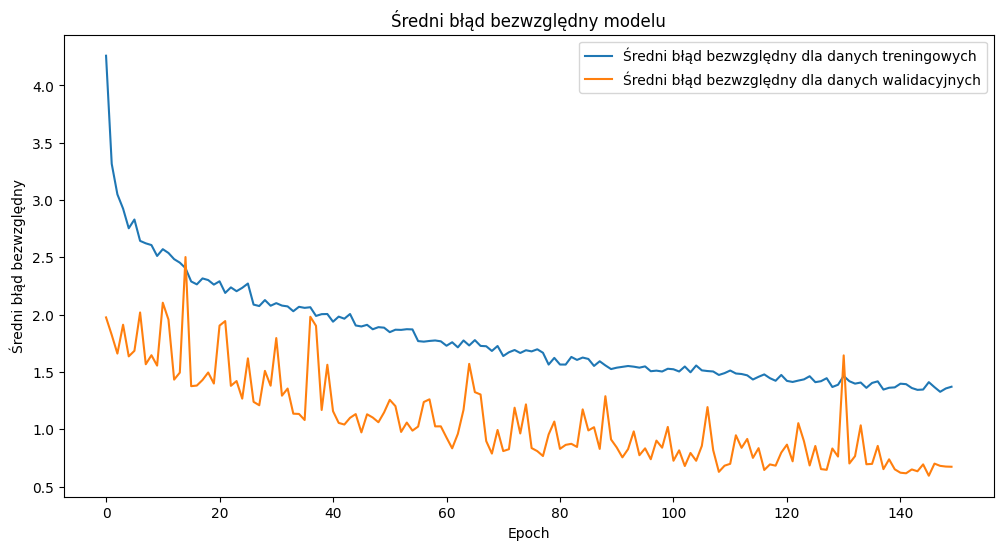

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step


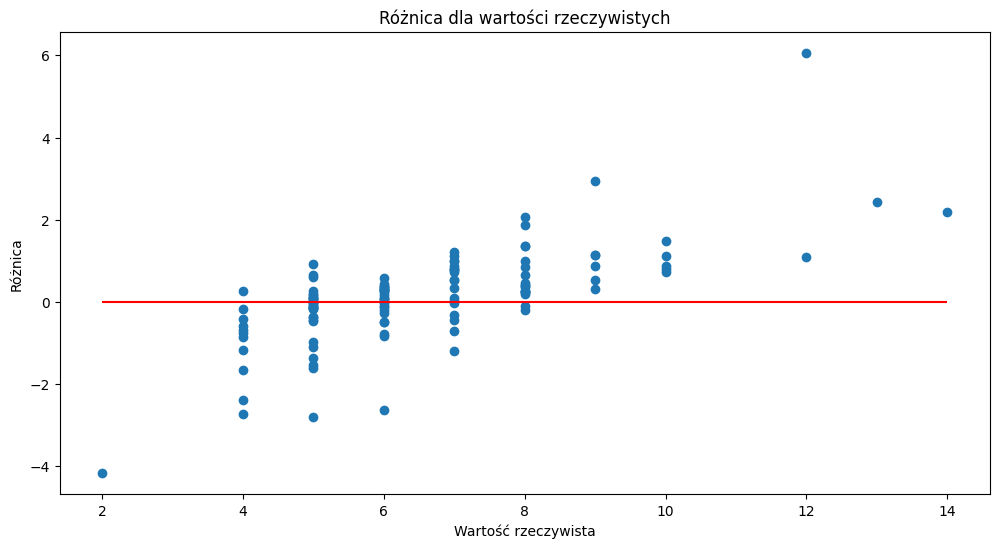

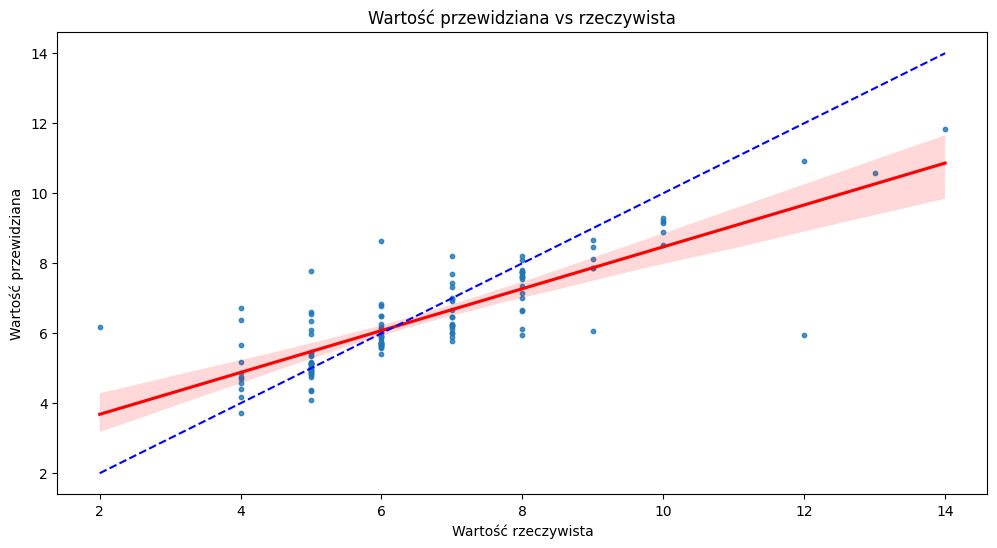

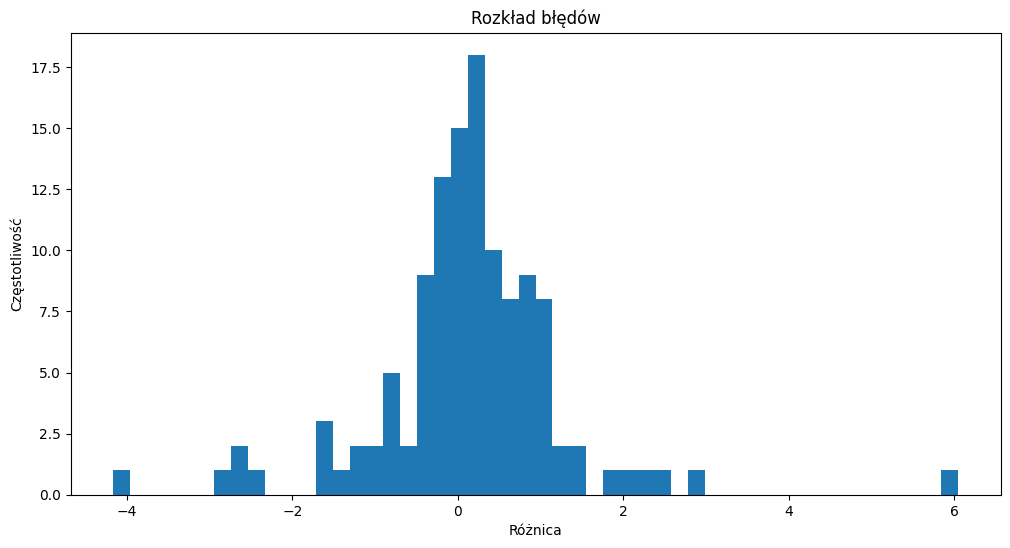

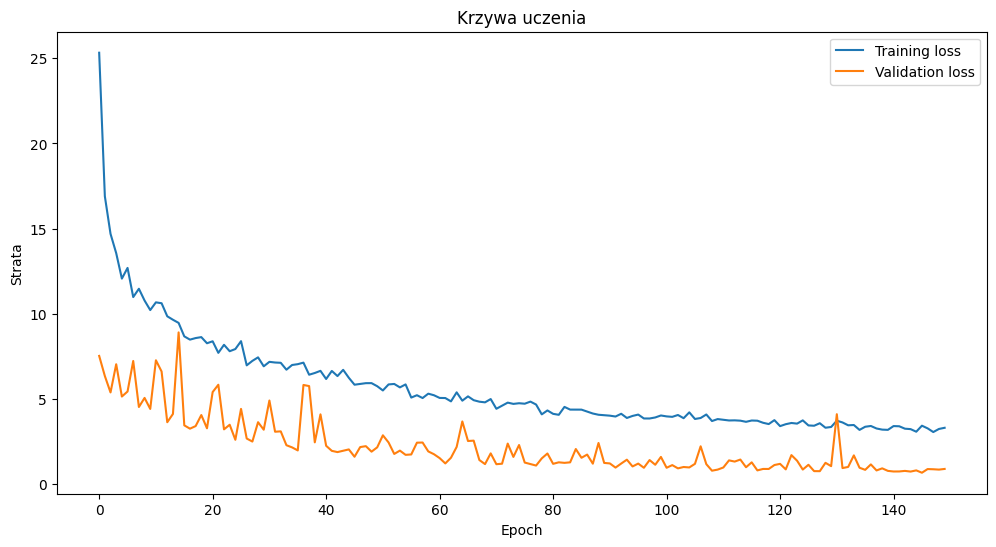

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pickle 
from keras.models import load_model
# Assuming `history` is the History object returned by model.fit()
# and `x_test_lstm`, `y_test` are the test datasets
with open('trainHistoryDict', "rb") as file_pi:
    history = pickle.load(file_pi)
model = load_model("model.h5")
model.load_weights('model.weights.h5')

import os
if not os.path.isdir("plots_training"):
    os.makedirs('plots_training')

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history['loss'], label='Strata dla danych treningowych')
plt.plot(history['val_loss'], label='Strata dla danych walidacyjnych')
plt.title('Strata modelu')
plt.xlabel('Epoch')
plt.ylabel('Strata')
plt.legend(loc='upper right')
plt.savefig("plots_training/Strata dla danych treningowych")
plt.show()

# Plot training & validation MAE values
plt.figure(figsize=(12, 6))
plt.plot(history['mae'], label='Średni błąd bezwzględny dla danych treningowych')
plt.plot(history['val_mae'], label='Średni błąd bezwzględny dla danych walidacyjnych')
plt.title('Średni błąd bezwzględny modelu')
plt.xlabel('Epoch')
plt.ylabel('Średni błąd bezwzględny')
plt.legend(loc='upper right')
plt.savefig("plots_training/Średni błąd bezwzględny dla danych treningowych")
plt.show()

# Make predictions
y_pred = model.predict(x_test_lstm)

# Residuals Plot
residuals = y_test - y_pred.flatten()
plt.figure(figsize=(12, 6))
plt.scatter(y_test, residuals)
plt.hlines(y=0, xmin=min(y_test), xmax=max(y_test), colors='r')
plt.title('Różnica dla wartości rzeczywistych')
plt.xlabel('Wartość rzeczywista')
plt.ylabel('Różnica')
plt.savefig("plots_training/Różnica dla wartości rzeczywistych")
plt.show()

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Załóżmy, że y_test i y_pred są dostępne jako NumPy array
y_test = np.array(y_test).ravel()  # Upewnij się, że y_test jest jednowymiarowy
y_pred = np.array(y_pred).ravel()  # Upewnij się, że y_pred jest jednowymiarowy

# Przekształć dane na DataFrame
df = pd.DataFrame({'Wartość rzeczywista': y_test, 'Wartość przewidziana': y_pred})

# Wykres Wartość przewidziana vs rzeczywista z regresją liniową
plt.figure(figsize=(12, 6))
sns.regplot(x='Wartość rzeczywista', y='Wartość przewidziana', data=df, scatter_kws={'s':10}, line_kws={"color": "red"})
plt.plot([min(df['Wartość rzeczywista']), max(df['Wartość rzeczywista'])], 
         [min(df['Wartość rzeczywista']), max(df['Wartość rzeczywista'])], 
         color='blue', linestyle='dashed')  # Linia idealnej predykcji
plt.title('Wartość przewidziana vs rzeczywista')
plt.xlabel('Wartość rzeczywista')
plt.ylabel('Wartość przewidziana')
plt.savefig("plots_training/Wartość przewidziana vs rzeczywista")
plt.show()


# Error Distribution (Histogram of residuals)
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=50)
plt.title('Rozkład błędów')
plt.xlabel('Różnica')
plt.ylabel('Częstotliwość')
plt.savefig("plots_training/Rozkład błędów")
plt.show()

# Learning Curves: Train vs Validation loss over batches
def plot_learning_curves(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history['loss'], label='Training loss')
    plt.plot(history['val_loss'], label='Validation loss')
    plt.title('Krzywa uczenia')
    plt.xlabel('Epoch')
    plt.ylabel('Strata')
    plt.legend()
    plt.savefig("plots_training/Krzywa uczenia")
    plt.show()

plot_learning_curves(history)


# Call the function to create the comprehensive plot
# plot_all_metrics(history, x_test_lstm, y_test, y_pred)


In [31]:
loss, mae = model.evaluate(x_test_lstm, y_test)
print(f'Test Loss: {loss}')
print(f'Test MAE: {mae}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 4.6766 - mean_absolute_error: 1.5830 
Test Loss: 4.654951095581055
Test MAE: 1.5835500955581665


In [1]:
import numpy as np
import librosa
from keras.models import load_model

def respiratory_rate_prediction(audio_path):
    # Load audio with 22050 Hz sampling rate
    # data_x, sampling_rate = librosa.load(audio_path, sr=22050)
    data_x, sampling_rate = librosa.load(audio_path, res_type='kaiser_fast')
    
    # Extract features using MFCC (50 features)
    features = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=50).T, axis=0)

    # Reshape features to match the model's input shape (1, 50, 1)
    features = features.reshape(1, 50, 1)
    
    # Get the prediction
    predicted_value = model.predict(features)[0][0]

    print(f'Predicted Respiratory Rate: {predicted_value}')

respiratory_rate_prediction("C:/Users/u144572/self_development/machine_learning_rr_detection/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.wav")

NameError: name 'model' is not defined

In [122]:
res_y[1]

34.5845487415067

In [123]:
rr_diagnosis_df

,patient_id,respiratory_rate
0,101,34.584549
1,102,39.593909
2,103,18.353301
3,104,26.274026
4,105,24.155805
...,...,...
121,222,12.113927
122,223,19.402063
123,224,21.060549
124,225,42.120042
